# Advanced Tutorial

This notebook dives deeper into the functionality of DeepSphere for TF 2.x. In contains examples of:
- Creating a padded survey masked
- Training on masked data
- Custom training loops
- More layers that are included in the package

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import healpy as hp
import numpy as np
import tensorflow as tf

from deepsphere import HealpyGCNN, healpy_layers as hp_layer
from deepsphere import utils

from tqdm import tqdm

## 1 Data loading

The data consists of a toy dataset that is sufficiently small to have fun with.
It is made of 200 maps of size `nside=64` splitted in 2 classes. 

The maps contain Gaussian random field realisations produced by the `synfast` function from `healpy`.
The input power spectra were taken from a ΛCDM model with two sets of parameters.
These maps are not realistic cosmological mass maps, just a toy dataset.
We downsampled them to `nside=64` to make processing faster.

In [2]:
data = np.load('../data/maps_downsampled_64.npz')
assert(len(data['class1']) == len(data['class2']))
nclass = len(data['class1'])

Let us plot a map of each class. It is not simple to visually catch the differences.

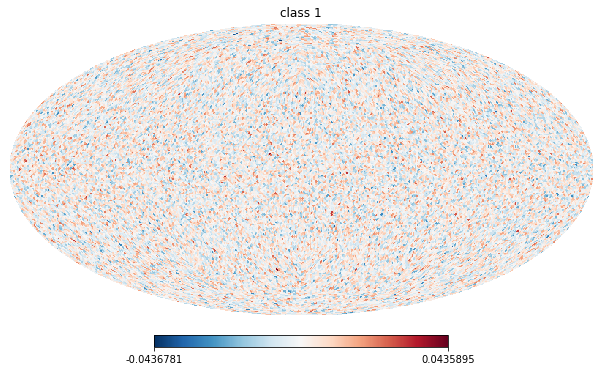

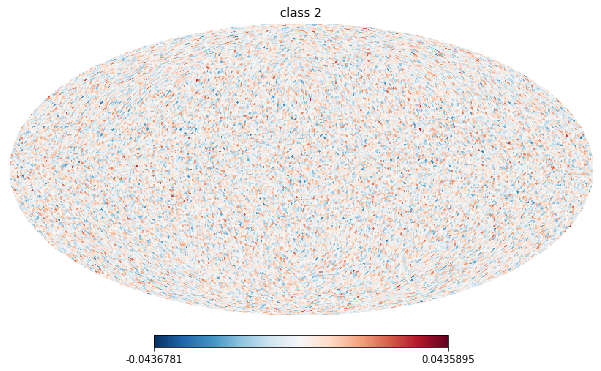

In [3]:
cmin = min(np.min(data['class1']), np.min(data['class2']))
cmax = max(np.max(data['class1']), np.max(data['class2']))
cm = plt.cm.RdBu_r
hp.mollview(data['class1'][0], title='class 1', nest=True, cmap=cm, min=cmin, max=cmax)
hp.mollview(data['class2'][0], title='class 2', nest=True, cmap=cm, min=cmin, max=cmax)

## 2 Survey mask creation and padding

Here we create a survey mask (usually this part is already pre-defined).

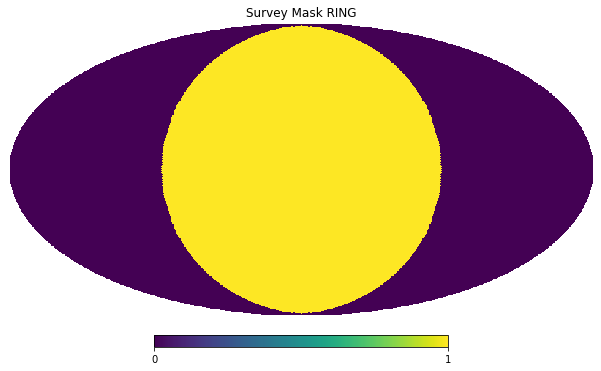

In [4]:
nside = 64
npix = hp.nside2npix(nside=nside)

relevant_pixel = hp.query_disc(nside=nside, vec=np.array([1.0, 0.0, 0.0]), radius=1.5)
boolian_mask = np.zeros(npix, dtype=np.bool)
boolian_mask[relevant_pixel] = 1

hp.mollview(boolian_mask, title="Survey Mask RING")

Note that DeepSphere usually expects everything concerning `healpy` to be in `NEST` ordering. So we will reorder the mask right now.

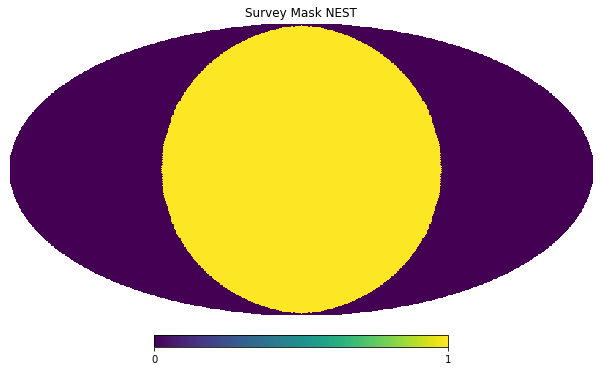

In [5]:
boolian_mask = hp.reorder(boolian_mask, r2n=True)
relevant_pixel = np.arange(npix)[boolian_mask]

hp.mollview(boolian_mask, title="Survey Mask NEST", nest=True)

During a forward pass one usually wants to downsample the input map using the hierarchical pixelization scheme of healpy and the appropriate layers of DeepSphere (see figure).

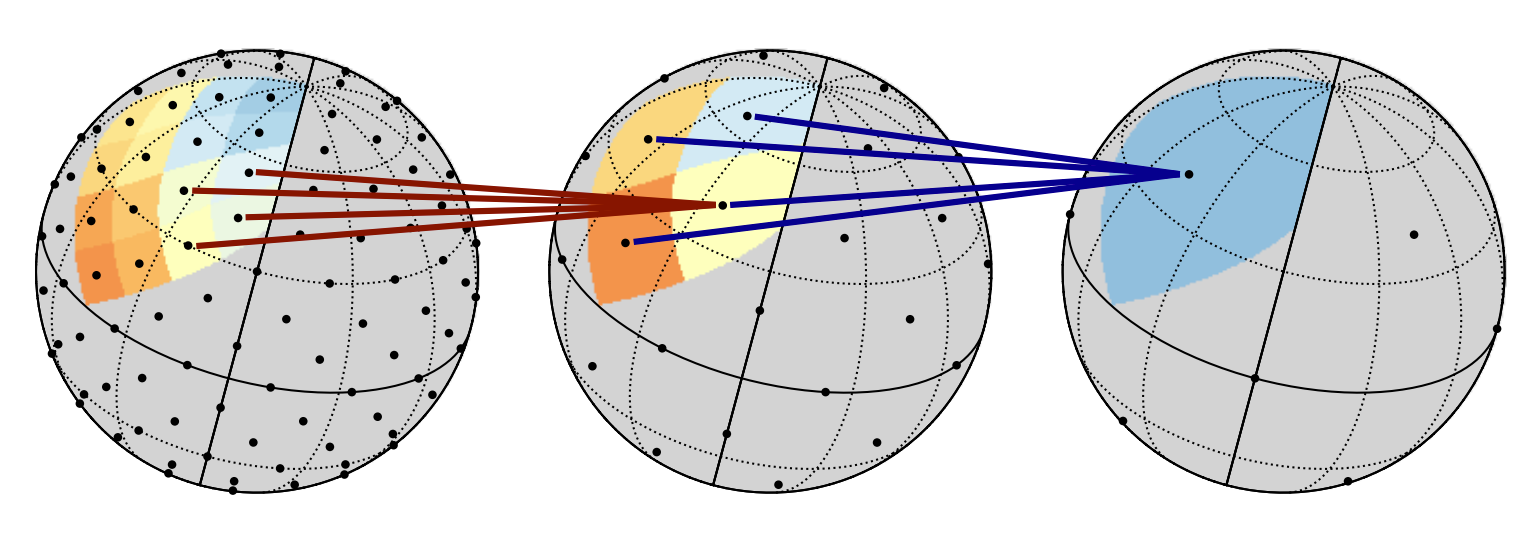

To make this possible, it is important that the survey mask includes all the relevant pixels, such that one can downsample the map properly. To make this possible one can apply a padding to the original mask. DeepSphere includes a function to automatically find the relevant pixels for the padding.

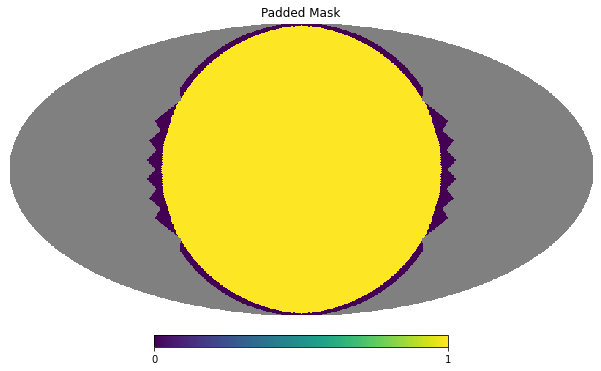

In [6]:
padded_pixel = utils.extend_indices(relevant_pixel, nside_in=nside, nside_out=8)

padded_mask = np.full(npix, hp.UNSEEN)
padded_mask[padded_pixel] = 0
padded_mask[relevant_pixel] = 1

hp.mollview(padded_mask, title="Padded Mask", nest=True)

## 3 Dataset creation

The masking and padding has to be done manually and will not be done by the network, mainly for efficiency. 

In [7]:
x_raw = np.concatenate([data["class1"], data["class2"]]).astype(np.float32)
labels = np.concatenate([np.zeros(nclass), np.ones(nclass)]).astype(np.float32)

x_pad = []
temp_map = np.zeros(npix)
for sample in x_raw:
    temp_map[relevant_pixel] = sample[relevant_pixel]
    x_pad.append(temp_map[padded_pixel])
x_pad = np.array(x_pad)[...,None]

We shuffle the data and split it into test and train data.

In [8]:
np.random.RandomState(11).shuffle(x_pad)
np.random.RandomState(11).shuffle(labels)

x_train, x_test = np.split(x_pad, indices_or_sections=[160])
y_train, y_test = np.split(labels, indices_or_sections=[160])

We create a tensorflow dataset.

In [9]:
dset_test = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_test),
                                 tf.data.Dataset.from_tensor_slices(y_test)))
dset_test = dset_test.batch(16)

dset_train = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_train),
                                  tf.data.Dataset.from_tensor_slices(y_train)))
dset_train = dset_train.shuffle(160)                                 
dset_train = dset_train.batch(16)

## 4 Building the Model

Here we will define a network and train it such that it can correctly classifiy the two classes of maps.
We start by defining the layers we want to use.
The `HealpyGCNN` class is a subclass of `tf.keras.Sequential`, meaning we can use a lot of the already existing TF functionality and can even interlace normal layers with our graph convolutions if we want to.

Below we give an example of most of the layers implemented in DeepSphere. To learn more about each layer use the `help()` or `?` function.

In [10]:
layers = [# this is a graph convolutional layer, it preserves the shape of the input
          hp_layer.HealpyChebyshev(K=10, Fout=5, use_bias=True, use_bn=True, 
                                   activation="relu"),
          # max pooling, it reduces the nside by 2**p
          hp_layer.HealpyPool(p=1, pool_type="MAX"),
          # another graph convolutional layer, it preserves the shape of the input
          hp_layer.HealpyMonomial(K=10, Fout=5, use_bias=True, use_bn=True, 
                                   activation="relu"),
          # average pooling, it reduces the nside by 2**p
          hp_layer.HealpyPool(p=1, pool_type="AVG"),
          # a residual layer using graph convolutions
          hp_layer.Healpy_ResidualLayer(layer_type="CHEBY", 
                                        layer_kwargs={"K": 10, "activation": "relu",
                                                      "use_bn": True, "use_bias": True},
                                        use_bn=False,
                                        activation="relu", alpha=0.1),
          # This layer reduces the nside by 2**p using learnable weights
          hp_layer.HealpyPseudoConv(Fout=2, p=1, activation="relu"),
          # we can interlace DeepSphere layer with any keras layer
          # note that you need to take care of the output shape yourself
          # if you want to follow with graph convolutions
          tf.keras.layers.Lambda(lambda x: tf.nn.softmax(tf.reduce_mean(x, axis=1),
                                                         axis=-1))]

Now we are ready to create the model.

In [11]:
tf.keras.backend.clear_session()
model = HealpyGCNN(nside=nside, indices=padded_pixel, layers=layers, n_neighbors=20)
model.build(input_shape=(None, len(padded_pixel), 1))
model.summary(110)

Detected a reduction factor of 8.0, the input with nside 64 will be transformed to 8 during a forward pass. Checking for consistency with indices...
indices seem consistent...
Model: "healpy_gcnn_1"
______________________________________________________________________________________________________________
Layer (type)                                     Output Shape                                Param #          
chebyshev (Chebyshev)                            (None, 24832, 5)                            65               
______________________________________________________________________________________________________________
healpy_pool (HealpyPool)                         (None, 6208, 5)                             0                
______________________________________________________________________________________________________________
monomial (Monomial)                              (None, 6208, 5)                             265              
________________________

## 5 Custom Training

The model itself is callable and there is no need for a session in TF 2.x.

In [12]:
for sample, label in dset_test.take(1):
    output = model(sample)
print(output)

tf.Tensor(
[[0.5640943  0.43590567]
 [0.56409425 0.4359058 ]
 [0.56409526 0.4359047 ]
 [0.5640952  0.43590477]
 [0.5640947  0.43590528]
 [0.5640953  0.43590468]
 [0.56409645 0.43590352]
 [0.5640961  0.43590385]
 [0.56409514 0.43590483]
 [0.5640944  0.43590552]
 [0.56409526 0.43590468]
 [0.5640951  0.4359049 ]
 [0.56409544 0.43590456]
 [0.56409377 0.4359062 ]
 [0.56409484 0.4359052 ]
 [0.5640949  0.43590513]], shape=(16, 2), dtype=float32)


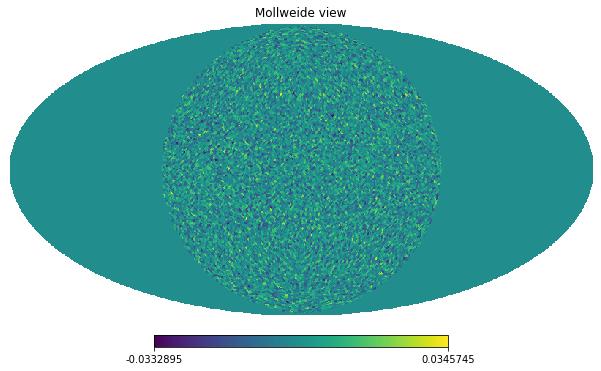

In [13]:
test_map = np.zeros(npix)
test_map[padded_pixel] = sample.numpy()[0,:,0]
hp.mollview(test_map, nest=True)

We define an optimizer and a loss function.

In [14]:
optimizer = tf.keras.optimizers.Adam(0.1)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

Wrapping the training step into a `@tf.function()` decorator leads to a significant performance boost. Note that it is very important to pass the `training=True` argument to the model during training, as layers like batch normalization behave differently during training and evaluation.

In [15]:
@tf.function()
def train_step(samples, labels):
    with tf.GradientTape() as tape:
        loss_val = loss(y_pred=model(samples, training=True), y_true=labels)
    gradients = gradients = tape.gradient(loss_val, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss_val

We train the network for a few epochs.

In [16]:
n_epochs = 50
for epoch in range(n_epochs):
    print(f"Starting with epoch {epoch + 1}/{n_epochs}", flush=True)
    with tqdm(dset_train, total=dset_train.cardinality().numpy()) as pbar:
        for samples, labels in pbar:
            loss_val = train_step(samples, labels)
            pbar.set_postfix(loss_val=loss_val.numpy(), refresh=False)
        for samples, labels in dset_test:
            predictions = model(samples, training=False)
            accuracy.update_state(y_true=labels, y_pred=predictions)
        print(f"Validation accuracy: {accuracy.result()}")

Starting with epoch 1/50


100%|██████████| 10/10 [00:10<00:00,  1.07s/it, loss_val=0.0525]


Validation accuracy: 0.5249999761581421
Starting with epoch 2/50


100%|██████████| 10/10 [00:08<00:00,  1.17it/s, loss_val=0.000683]


Validation accuracy: 0.5249999761581421
Starting with epoch 3/50


100%|██████████| 10/10 [00:08<00:00,  1.19it/s, loss_val=0.00031]


Validation accuracy: 0.5083333253860474
Starting with epoch 4/50


100%|██████████| 10/10 [00:08<00:00,  1.19it/s, loss_val=0.000179]


Validation accuracy: 0.5
Starting with epoch 5/50


100%|██████████| 10/10 [00:04<00:00,  2.10it/s, loss_val=4.75e-5]


Validation accuracy: 0.4950000047683716
Starting with epoch 6/50


100%|██████████| 10/10 [00:05<00:00,  1.77it/s, loss_val=1.34e-5]


Validation accuracy: 0.49166667461395264
Starting with epoch 7/50


100%|██████████| 10/10 [00:07<00:00,  1.39it/s, loss_val=1.85e-6]


Validation accuracy: 0.5642856955528259
Starting with epoch 8/50


100%|██████████| 10/10 [00:09<00:00,  1.11it/s, loss_val=8.6e-6] 


Validation accuracy: 0.6187499761581421
Starting with epoch 9/50


100%|██████████| 10/10 [00:07<00:00,  1.29it/s, loss_val=1.56e-6]


Validation accuracy: 0.6611111164093018
Starting with epoch 10/50


100%|██████████| 10/10 [00:06<00:00,  1.52it/s, loss_val=3.06e-6]


Validation accuracy: 0.6949999928474426
Starting with epoch 11/50


100%|██████████| 10/10 [00:06<00:00,  1.61it/s, loss_val=1.36e-6]


Validation accuracy: 0.7227272987365723
Starting with epoch 12/50


100%|██████████| 10/10 [00:06<00:00,  1.64it/s, loss_val=1.07e-5]


Validation accuracy: 0.7437499761581421
Starting with epoch 13/50


100%|██████████| 10/10 [00:06<00:00,  1.60it/s, loss_val=0.000105]


Validation accuracy: 0.7634615302085876
Starting with epoch 14/50


100%|██████████| 10/10 [00:08<00:00,  1.22it/s, loss_val=0.0019] 


Validation accuracy: 0.7803571224212646
Starting with epoch 15/50


100%|██████████| 10/10 [00:06<00:00,  1.50it/s, loss_val=4.35e-5]


Validation accuracy: 0.7933333516120911
Starting with epoch 16/50


100%|██████████| 10/10 [00:07<00:00,  1.26it/s, loss_val=0.000534]


Validation accuracy: 0.8062499761581421
Starting with epoch 17/50


100%|██████████| 10/10 [00:07<00:00,  1.36it/s, loss_val=6e-6]  


Validation accuracy: 0.8176470398902893
Starting with epoch 18/50


100%|██████████| 10/10 [00:07<00:00,  1.39it/s, loss_val=8.22e-6]


Validation accuracy: 0.8277778029441833
Starting with epoch 19/50


100%|██████████| 10/10 [00:07<00:00,  1.29it/s, loss_val=1.53e-6]


Validation accuracy: 0.8368421196937561
Starting with epoch 20/50


100%|██████████| 10/10 [00:05<00:00,  1.99it/s, loss_val=2.15e-6]


Validation accuracy: 0.8450000286102295
Starting with epoch 21/50


100%|██████████| 10/10 [00:04<00:00,  2.22it/s, loss_val=1.11e-6]


Validation accuracy: 0.8523809313774109
Starting with epoch 22/50


100%|██████████| 10/10 [00:04<00:00,  2.22it/s, loss_val=1.03e-6]


Validation accuracy: 0.8590909242630005
Starting with epoch 23/50


100%|██████████| 10/10 [00:04<00:00,  2.26it/s, loss_val=1.39e-5]


Validation accuracy: 0.865217387676239
Starting with epoch 24/50


100%|██████████| 10/10 [00:04<00:00,  2.22it/s, loss_val=2.11e-6]


Validation accuracy: 0.8708333373069763
Starting with epoch 25/50


100%|██████████| 10/10 [00:04<00:00,  2.13it/s, loss_val=4.09e-5]


Validation accuracy: 0.8759999871253967
Starting with epoch 26/50


100%|██████████| 10/10 [00:05<00:00,  2.00it/s, loss_val=7.32e-6]


Validation accuracy: 0.8807692527770996
Starting with epoch 27/50


100%|██████████| 10/10 [00:04<00:00,  2.02it/s, loss_val=2.75e-6]


Validation accuracy: 0.885185182094574
Starting with epoch 28/50


100%|██████████| 10/10 [00:03<00:00,  2.54it/s, loss_val=3.26e-6]


Validation accuracy: 0.8892857432365417
Starting with epoch 29/50


100%|██████████| 10/10 [00:04<00:00,  2.24it/s, loss_val=1.53e-5]


Validation accuracy: 0.8931034207344055
Starting with epoch 30/50


100%|██████████| 10/10 [00:04<00:00,  2.20it/s, loss_val=1.87e-5]


Validation accuracy: 0.8966666460037231
Starting with epoch 31/50


100%|██████████| 10/10 [00:04<00:00,  2.28it/s, loss_val=0.000356]


Validation accuracy: 0.8846774101257324
Starting with epoch 32/50


100%|██████████| 10/10 [00:04<00:00,  2.45it/s, loss_val=0.00112]


Validation accuracy: 0.8734375238418579
Starting with epoch 33/50


100%|██████████| 10/10 [00:03<00:00,  2.78it/s, loss_val=5.53e-6]


Validation accuracy: 0.8628787994384766
Starting with epoch 34/50


100%|██████████| 10/10 [00:03<00:00,  2.88it/s, loss_val=6.77e-5]


Validation accuracy: 0.8529411554336548
Starting with epoch 35/50


100%|██████████| 10/10 [00:03<00:00,  2.91it/s, loss_val=2.18e-5]


Validation accuracy: 0.8571428656578064
Starting with epoch 36/50


100%|██████████| 10/10 [00:03<00:00,  2.90it/s, loss_val=1.44e-6]


Validation accuracy: 0.8479166626930237
Starting with epoch 37/50


100%|██████████| 10/10 [00:03<00:00,  2.72it/s, loss_val=0.000212]


Validation accuracy: 0.8391891717910767
Starting with epoch 38/50


100%|██████████| 10/10 [00:04<00:00,  2.30it/s, loss_val=0.000377]


Validation accuracy: 0.8309210538864136
Starting with epoch 39/50


100%|██████████| 10/10 [00:04<00:00,  2.45it/s, loss_val=2.89e-5]


Validation accuracy: 0.8230769038200378
Starting with epoch 40/50


100%|██████████| 10/10 [00:04<00:00,  2.37it/s, loss_val=0.000206]


Validation accuracy: 0.8218749761581421
Starting with epoch 41/50


100%|██████████| 10/10 [00:03<00:00,  2.63it/s, loss_val=7.71e-5]


Validation accuracy: 0.824999988079071
Starting with epoch 42/50


100%|██████████| 10/10 [00:04<00:00,  2.49it/s, loss_val=0.000238]


Validation accuracy: 0.8291666507720947
Starting with epoch 43/50


100%|██████████| 10/10 [00:04<00:00,  2.42it/s, loss_val=3.31e-5]


Validation accuracy: 0.8331395387649536
Starting with epoch 44/50


100%|██████████| 10/10 [00:03<00:00,  2.62it/s, loss_val=6.78e-5]


Validation accuracy: 0.8369318246841431
Starting with epoch 45/50


100%|██████████| 10/10 [00:03<00:00,  2.54it/s, loss_val=2.42e-5]


Validation accuracy: 0.8405555486679077
Starting with epoch 46/50


100%|██████████| 10/10 [00:04<00:00,  2.26it/s, loss_val=5.92e-5]


Validation accuracy: 0.844021737575531
Starting with epoch 47/50


100%|██████████| 10/10 [00:04<00:00,  2.19it/s, loss_val=1.01e-5]


Validation accuracy: 0.8473404049873352
Starting with epoch 48/50


100%|██████████| 10/10 [00:04<00:00,  2.12it/s, loss_val=1.57e-5]


Validation accuracy: 0.8505208492279053
Starting with epoch 49/50


100%|██████████| 10/10 [00:04<00:00,  2.45it/s, loss_val=1e-5]   


Validation accuracy: 0.8535714149475098
Starting with epoch 50/50


100%|██████████| 10/10 [00:04<00:00,  2.39it/s, loss_val=1.1e-5] 


Validation accuracy: 0.8565000295639038


If we want to do actual predictions, we just call the model again.

In [17]:
for sample, label in dset_test.take(1):
    output = model(sample)
print("Raw output: ", output)
print("Class output: ", tf.argmax(output, axis=1))
print("Correct classification: ", tf.argmax(output, axis=1) == tf.cast(label, tf.int64))

Raw output:  tf.Tensor(
[[2.6505001e-08 1.0000000e+00]
 [4.6613783e-07 9.9999952e-01]
 [9.9999440e-01 5.6590025e-06]
 [1.4907311e-04 9.9985087e-01]
 [1.6605404e-06 9.9999833e-01]
 [9.9999189e-01 8.1651706e-06]
 [1.0000000e+00 4.8189094e-08]
 [9.9999976e-01 2.9309149e-07]
 [5.4218435e-05 9.9994576e-01]
 [4.3714892e-05 9.9995625e-01]
 [9.9999642e-01 3.5216892e-06]
 [9.9999380e-01 6.2163626e-06]
 [3.0687247e-06 9.9999690e-01]
 [2.7259484e-09 1.0000000e+00]
 [2.7214280e-06 9.9999726e-01]
 [9.0226132e-07 9.9999905e-01]], shape=(16, 2), dtype=float32)
Class output:  tf.Tensor([1 1 0 1 1 0 0 0 1 1 0 0 1 1 1 1], shape=(16,), dtype=int64)
Correct classification:  tf.Tensor(
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True], shape=(16,), dtype=bool)


## 6 Filter Visualization

We observe the coefficiencts of the Chebyshev polynomials.
It is mostly interpretable by people for the graph signal processing community.

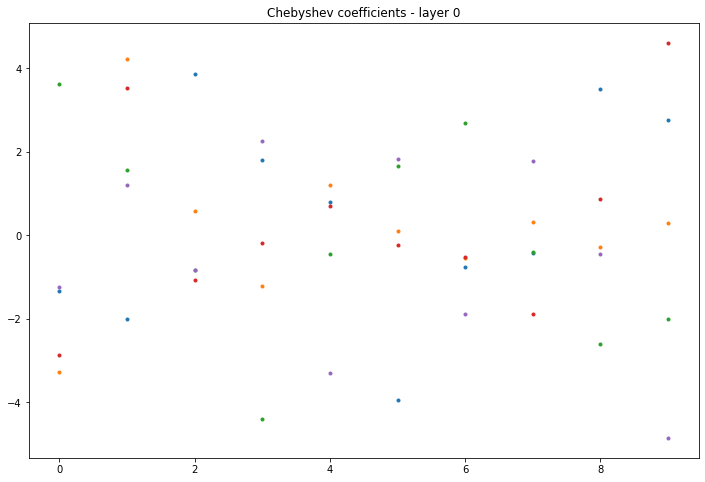

In [18]:
layer=0
plt.figure(figsize=(12,8))
model.plot_chebyshev_coeffs(layer)

We observe the filters in the graph spectral domain.
This visuallization can help to understand which graph frequencies are picked by the filtering operation.

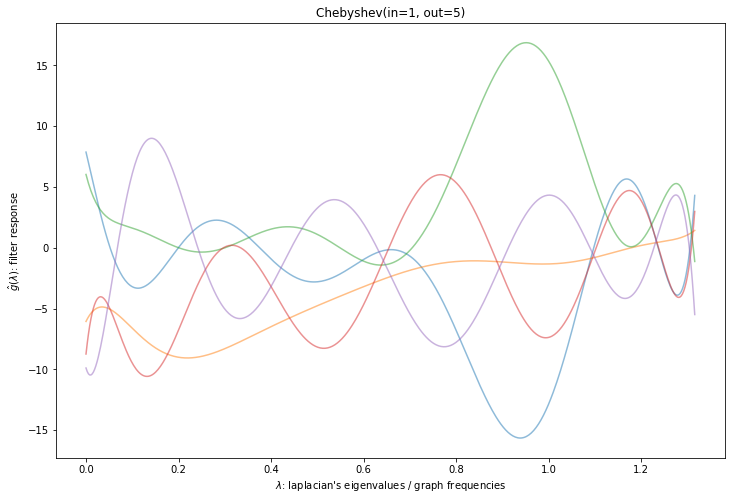

In [19]:
plt.figure(figsize=(12,8))
model.plot_filters_spectral(layer)

Here comes one of the most human friendly representation of the filters. It consists the section of the filters "projected" on the sphere. Because of the irregularity of the healpix sampling, this representation of the filters may not look very smooth.

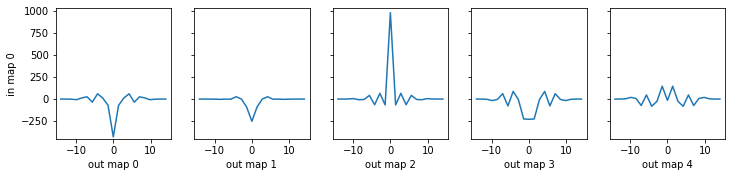

In [20]:
model.plot_filters_section(layer, title='');

Eventually, we can simply look at the filters on sphere. This representation clearly displays the sampling artifacts.

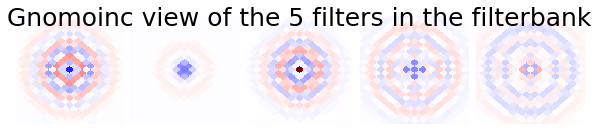

In [21]:
figs = model.plot_filters_gnomonic(layer, title=None)